Summary:
- $(0,1)$ may be predicted if
    - $0.27 < temp ≤ 0.54$ and
        - $atemp ≤ 0.48, weathersit ≤ 1$ or
        - $atemp ≤ 0.71, 0.17 < windspeed, 2 ≤ weathersit$
    - $0.54 < temp$ and
        - $atemp ≤ 0.71, 5 ≤ mnth, 0.19 < windspeed, 0.65 < hum$ or
        - $0.71 < atemp$
- $(1,0)$ may be predicted if
    - $0.15 < windspeed < 0.16, 11 ≤ mnth$

In [1]:
import pandas as pd
import numpy as np
import pickle
import shap
import matplotlib.pyplot as plt
from IPython.display import display
from ast import literal_eval
from comparers import ModelComparer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from baseline import print_rules
from tasks.bike_sharing import make_task
from diro2c_wrapper import CombinationClassifier, ConstantClassifier

XGBoost prints many warnings, that are safe to ignore:

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
clf_a, clf_b, X, y, feature_names = make_task()

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

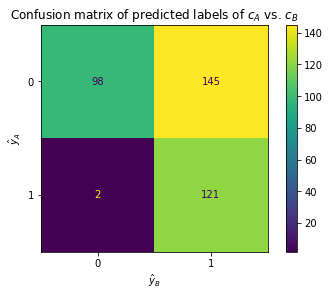

In [5]:
comparer.plot_confusion_matrix(X)

# General Explanations

In [6]:
is_pred_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

In [7]:
mclass_tree = DecisionTreeClassifier(max_depth=3)
mclass_tree.fit(X, mclass_diff)
class_names = comparer.class_names[mclass_tree.classes_]

In [8]:
feature_importances = mclass_tree.feature_importances_
feature_order = np.flip(np.argsort(feature_importances))

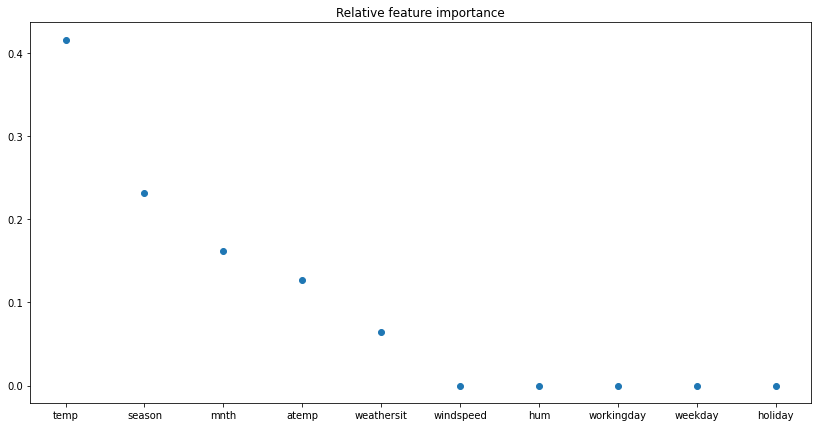

In [9]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

In [10]:
class_names

array(['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)'], dtype='<U6')

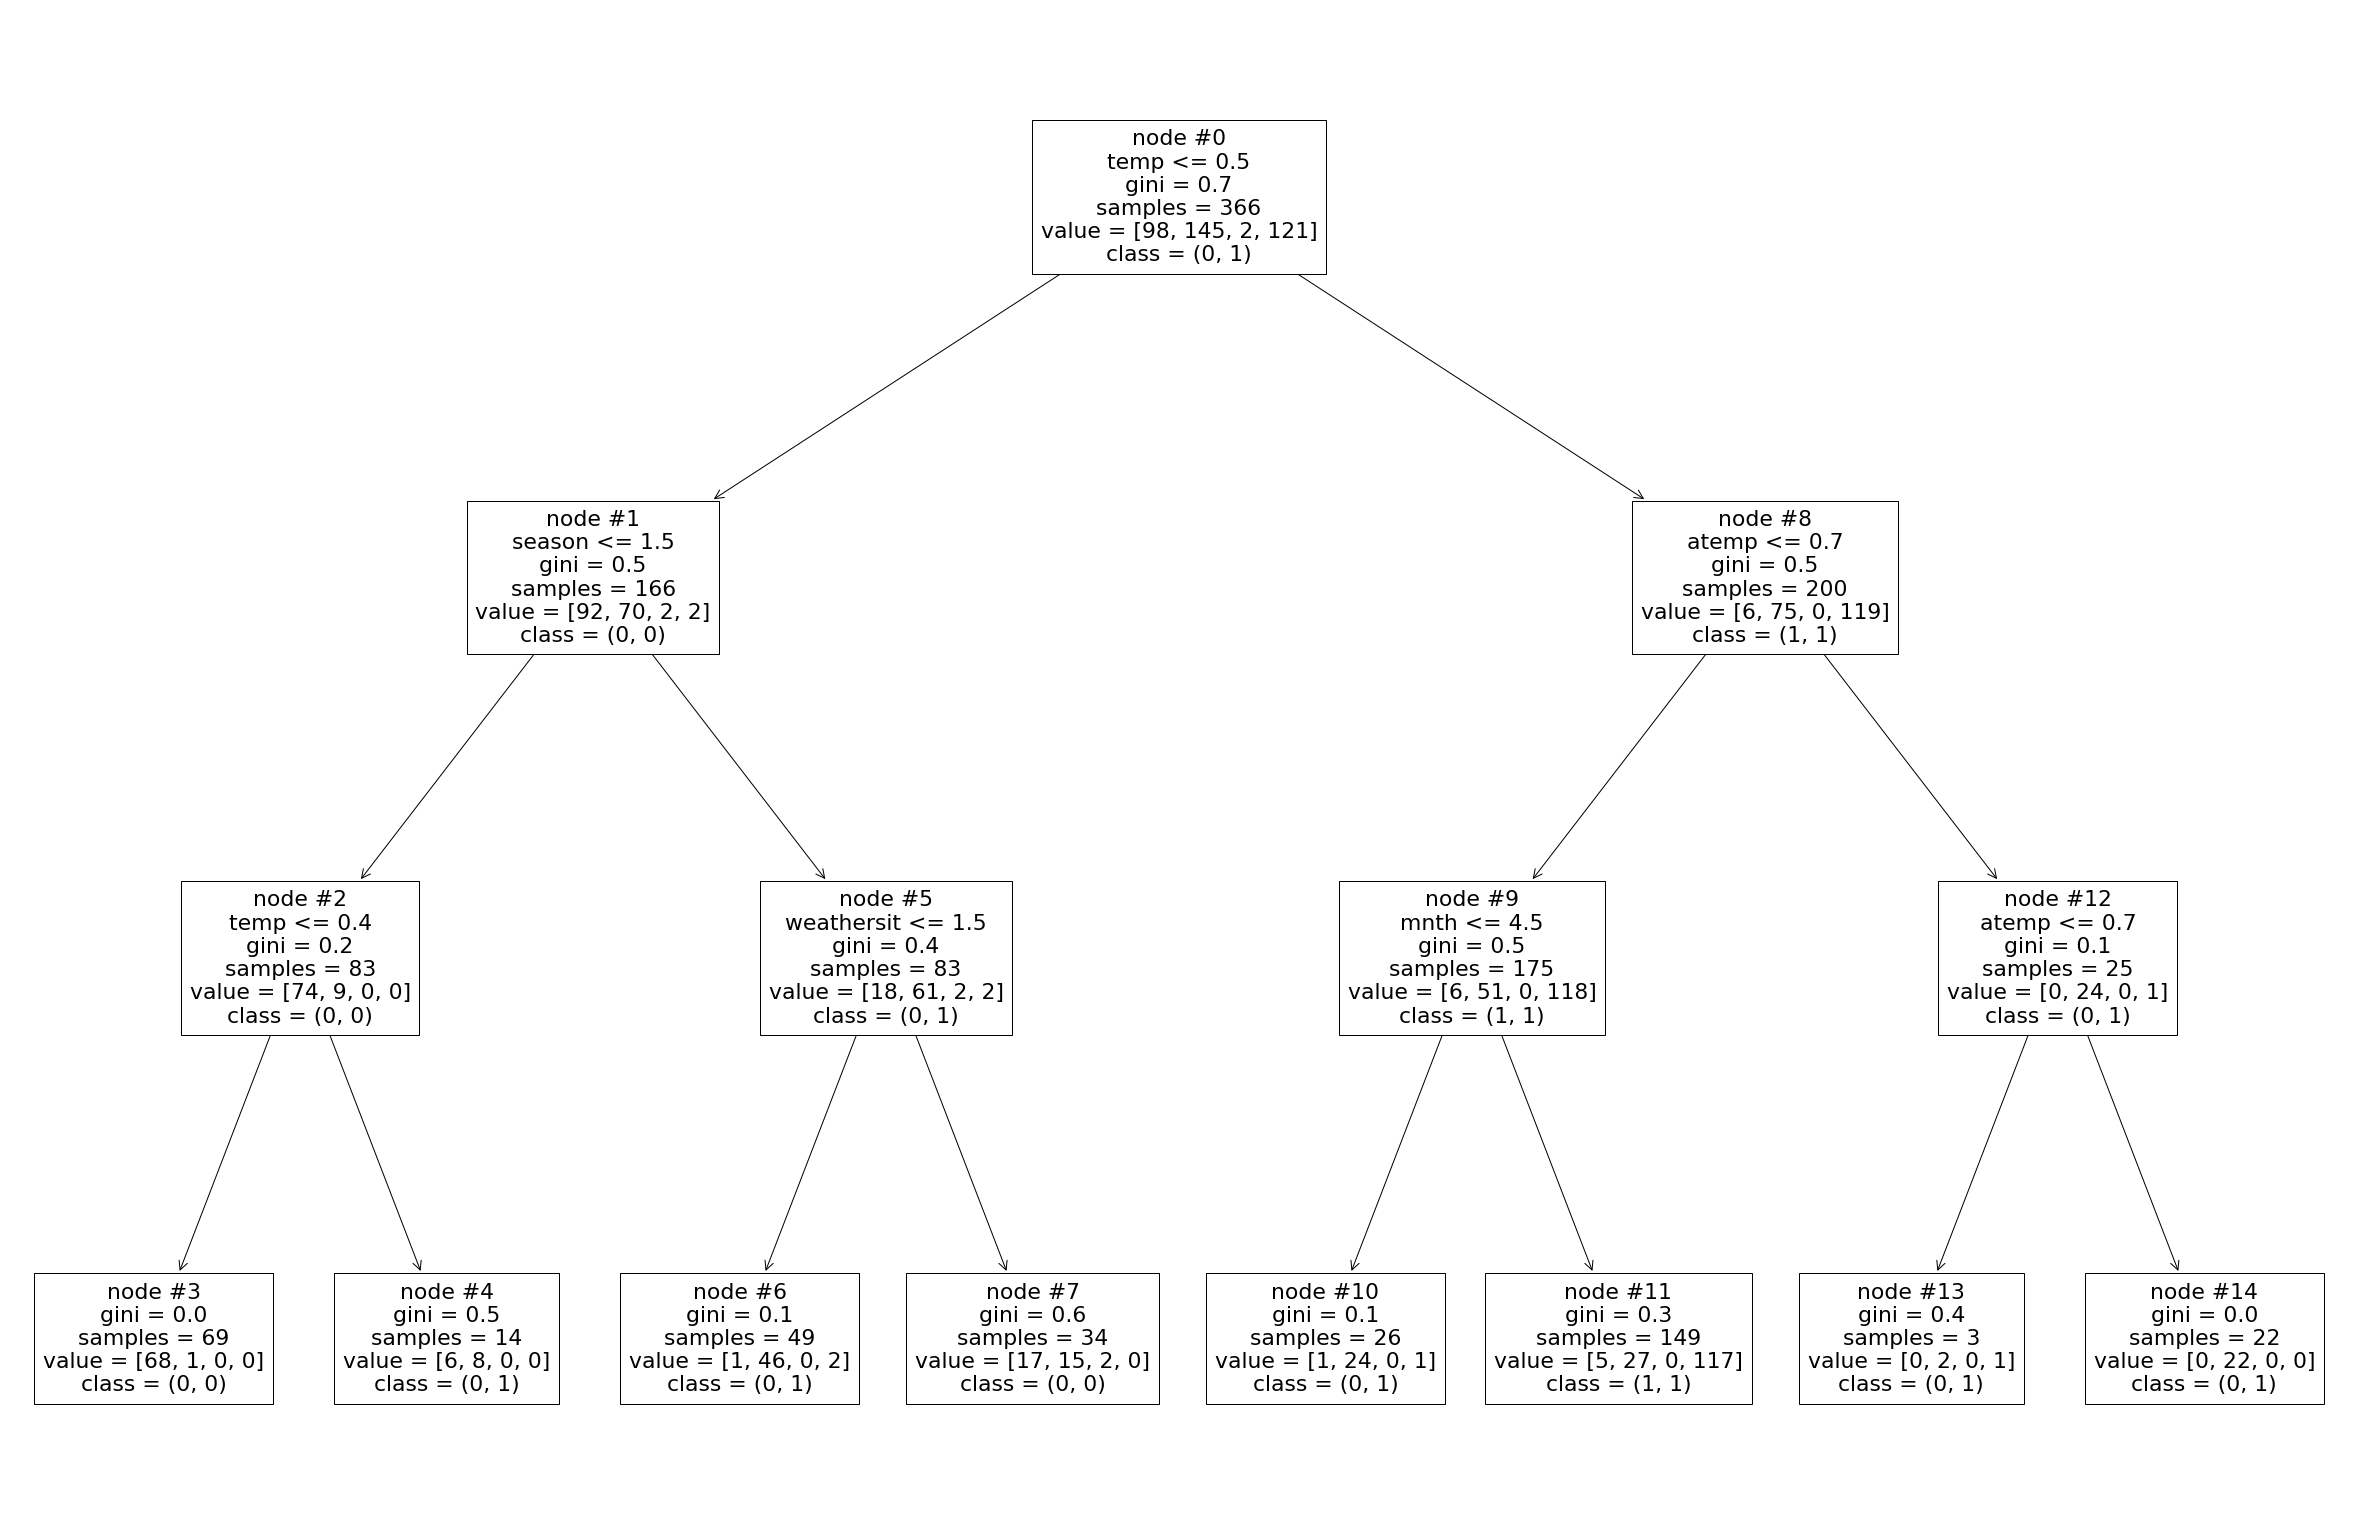

In [11]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(mclass_tree, feature_names=comparer.feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [12]:
print_rules(mclass_tree, feature_names, class_names, '(0, 1)', feature_order, precision=2)

node #6: if (temp <= 0.47) and (season > 1.5) and (weathersit <= 1.5) then class: (0, 1) (46/49 instances)
node #10: if (temp > 0.47) and (mnth <= 4.5) and (atemp <= 0.7) then class: (0, 1) (24/26 instances)
node #14: if (temp > 0.47) and (atemp > 0.71) then class: (0, 1) (22/22 instances)
node #4: if (temp > 0.39) and (temp <= 0.47) and (season <= 1.5) then class: (0, 1) (8/14 instances)
node #13: if (temp > 0.47) and (atemp > 0.7) and (atemp <= 0.71) then class: (0, 1) (2/3 instances)


In [13]:
print_rules(mclass_tree, feature_names, class_names, '(1, 0)', feature_order, precision=2)

Because of the imbalance of the number of instances of the difference classes, it's not easy to explain both with one surrogate model. I will explain each in a one-vs-rest manner:

# Explanations for class $(0,1)$

In [14]:
focus_class = '(0, 1)'

In [15]:
mclass_tree = DecisionTreeClassifier(max_depth=6)
mclass_tree.fit(X, CombinationClassifier(comparer, *literal_eval(focus_class)).predict(X))
class_names = np.array(['other', focus_class])

In [16]:
feature_importances = mclass_tree.feature_importances_
feature_order = np.flip(np.argsort(feature_importances))

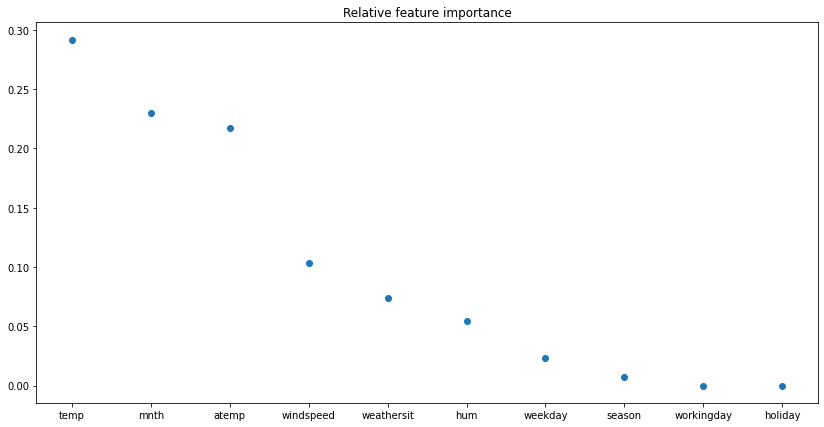

In [17]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

In [18]:
class_names

array(['other', '(0, 1)'], dtype='<U6')

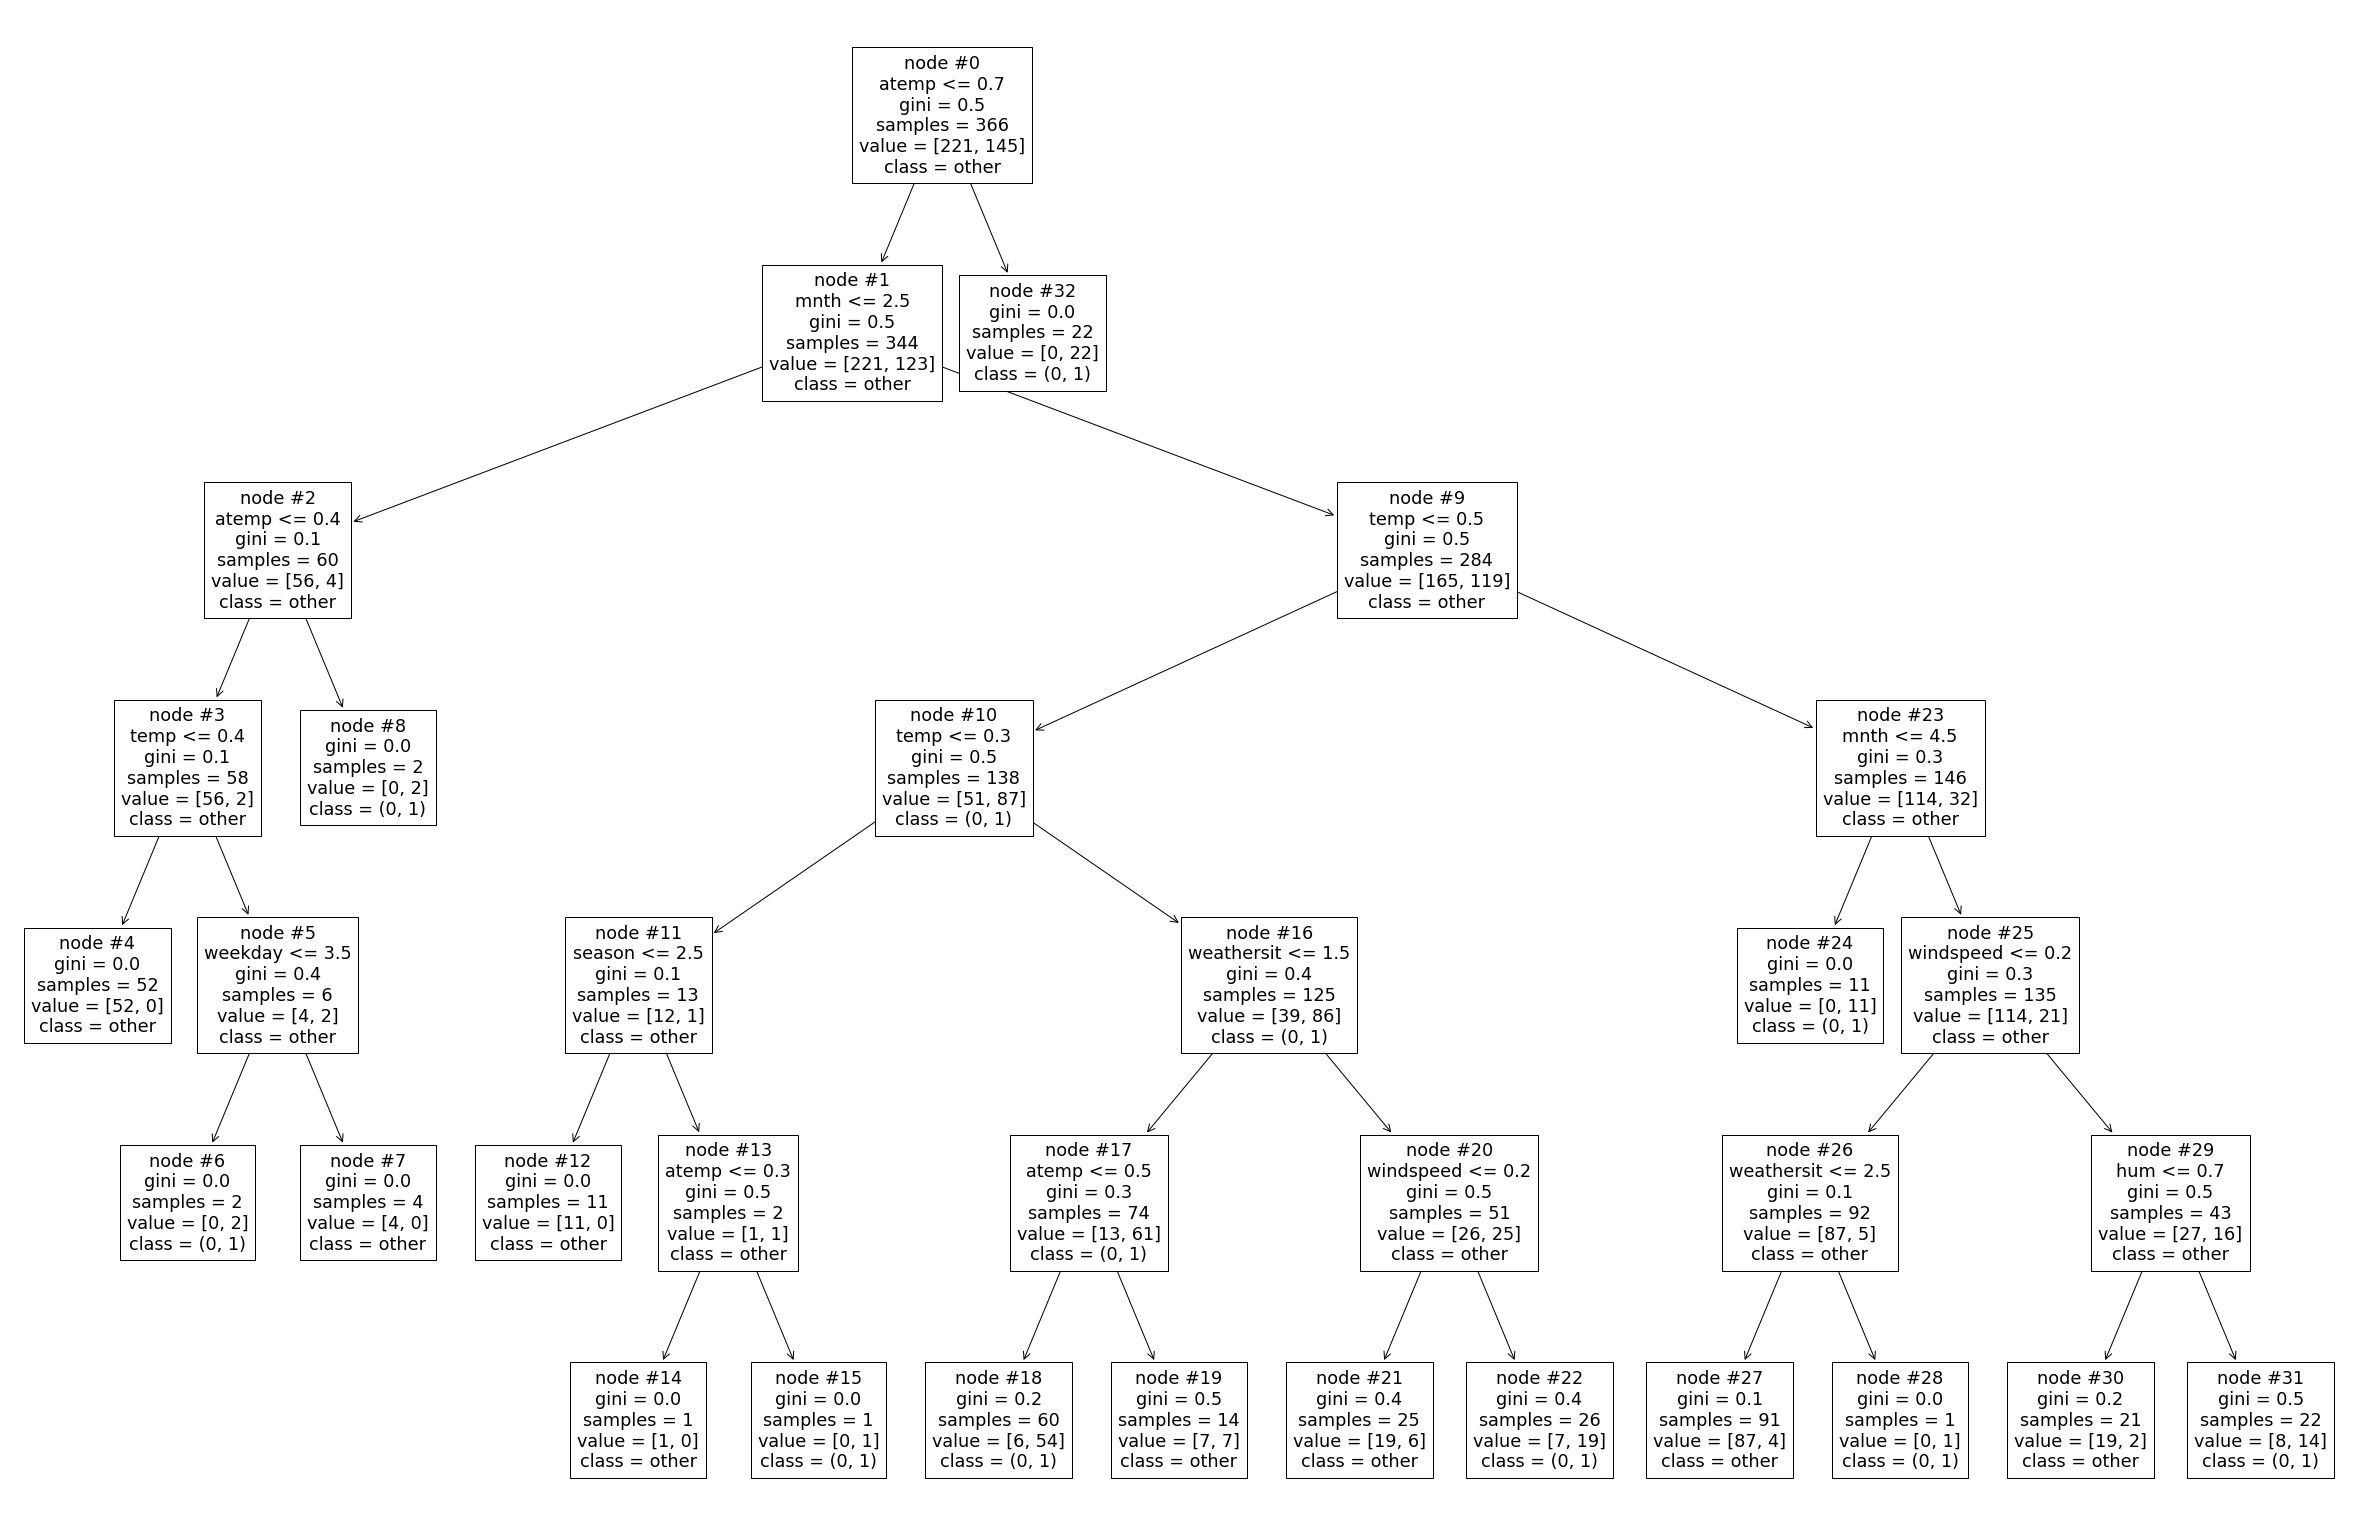

In [19]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(mclass_tree, feature_names=comparer.feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [20]:
print_rules(mclass_tree, feature_names, class_names, focus_class, feature_order, precision=2)

node #18: if (temp > 0.27) and (temp <= 0.54) and (mnth > 2.5) and (atemp <= 0.48) and (weathersit <= 1.5) then class: (0, 1) (54/60 instances)
node #22: if (temp > 0.27) and (temp <= 0.54) and (mnth > 2.5) and (atemp <= 0.71) and (windspeed > 0.17) and (weathersit > 1.5) then class: (0, 1) (19/26 instances)
node #31: if (temp > 0.54) and (mnth > 4.5) and (atemp <= 0.71) and (windspeed > 0.19) and (hum > 0.65) then class: (0, 1) (14/22 instances)
node #32: if (atemp > 0.71) then class: (0, 1) (22/22 instances)
node #24: if (temp > 0.54) and (mnth > 2.5) and (mnth <= 4.5) and (atemp <= 0.71) then class: (0, 1) (11/11 instances)
node #8: if (mnth <= 2.5) and (atemp > 0.43) and (atemp <= 0.71) then class: (0, 1) (2/2 instances)
node #6: if (temp > 0.39) and (mnth <= 2.5) and (atemp <= 0.43) and (weekday <= 3.5) then class: (0, 1) (2/2 instances)
node #28: if (temp > 0.54) and (mnth > 4.5) and (atemp <= 0.71) and (windspeed <= 0.19) and (weathersit > 2.5) then class: (0, 1) (1/1 instances)

In [21]:
(54+19+14+22)/145

0.7517241379310344

The first four rules cover the majority of the instances classified $(0,1)$.

Observed differences are due to:
- $0.27 < temp ≤ 0.54, 3 ≤ mnth$ and
    - $atemp ≤ 0.48, weathersit ≤ 1$ or
    - $atemp ≤ 0.71, 0.17 < windspeed, 2 ≤ weathersit$; or
- $0.54 < temp, 5 ≤ mnth, atemp ≤ 0.71, 0.19 < windspeed, 0.65 < hum$ or
- $0.71<atemp$.

# Explanations for class $(1,0)$

In [22]:
focus_class = '(1, 0)'

In [23]:
mclass_tree = DecisionTreeClassifier(max_depth=6)
mclass_tree.fit(X, CombinationClassifier(comparer, *literal_eval(focus_class)).predict(X))
class_names = np.array(['other', focus_class])

In [24]:
feature_importances = mclass_tree.feature_importances_
feature_order = np.flip(np.argsort(feature_importances))

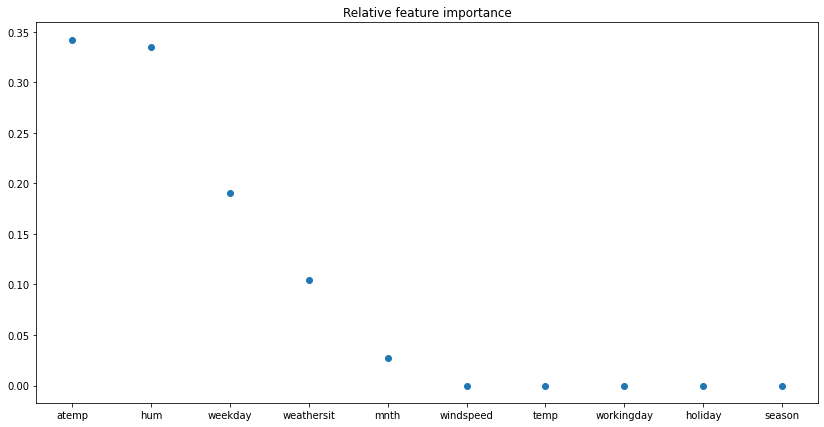

In [25]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

In [26]:
class_names

array(['other', '(1, 0)'], dtype='<U6')

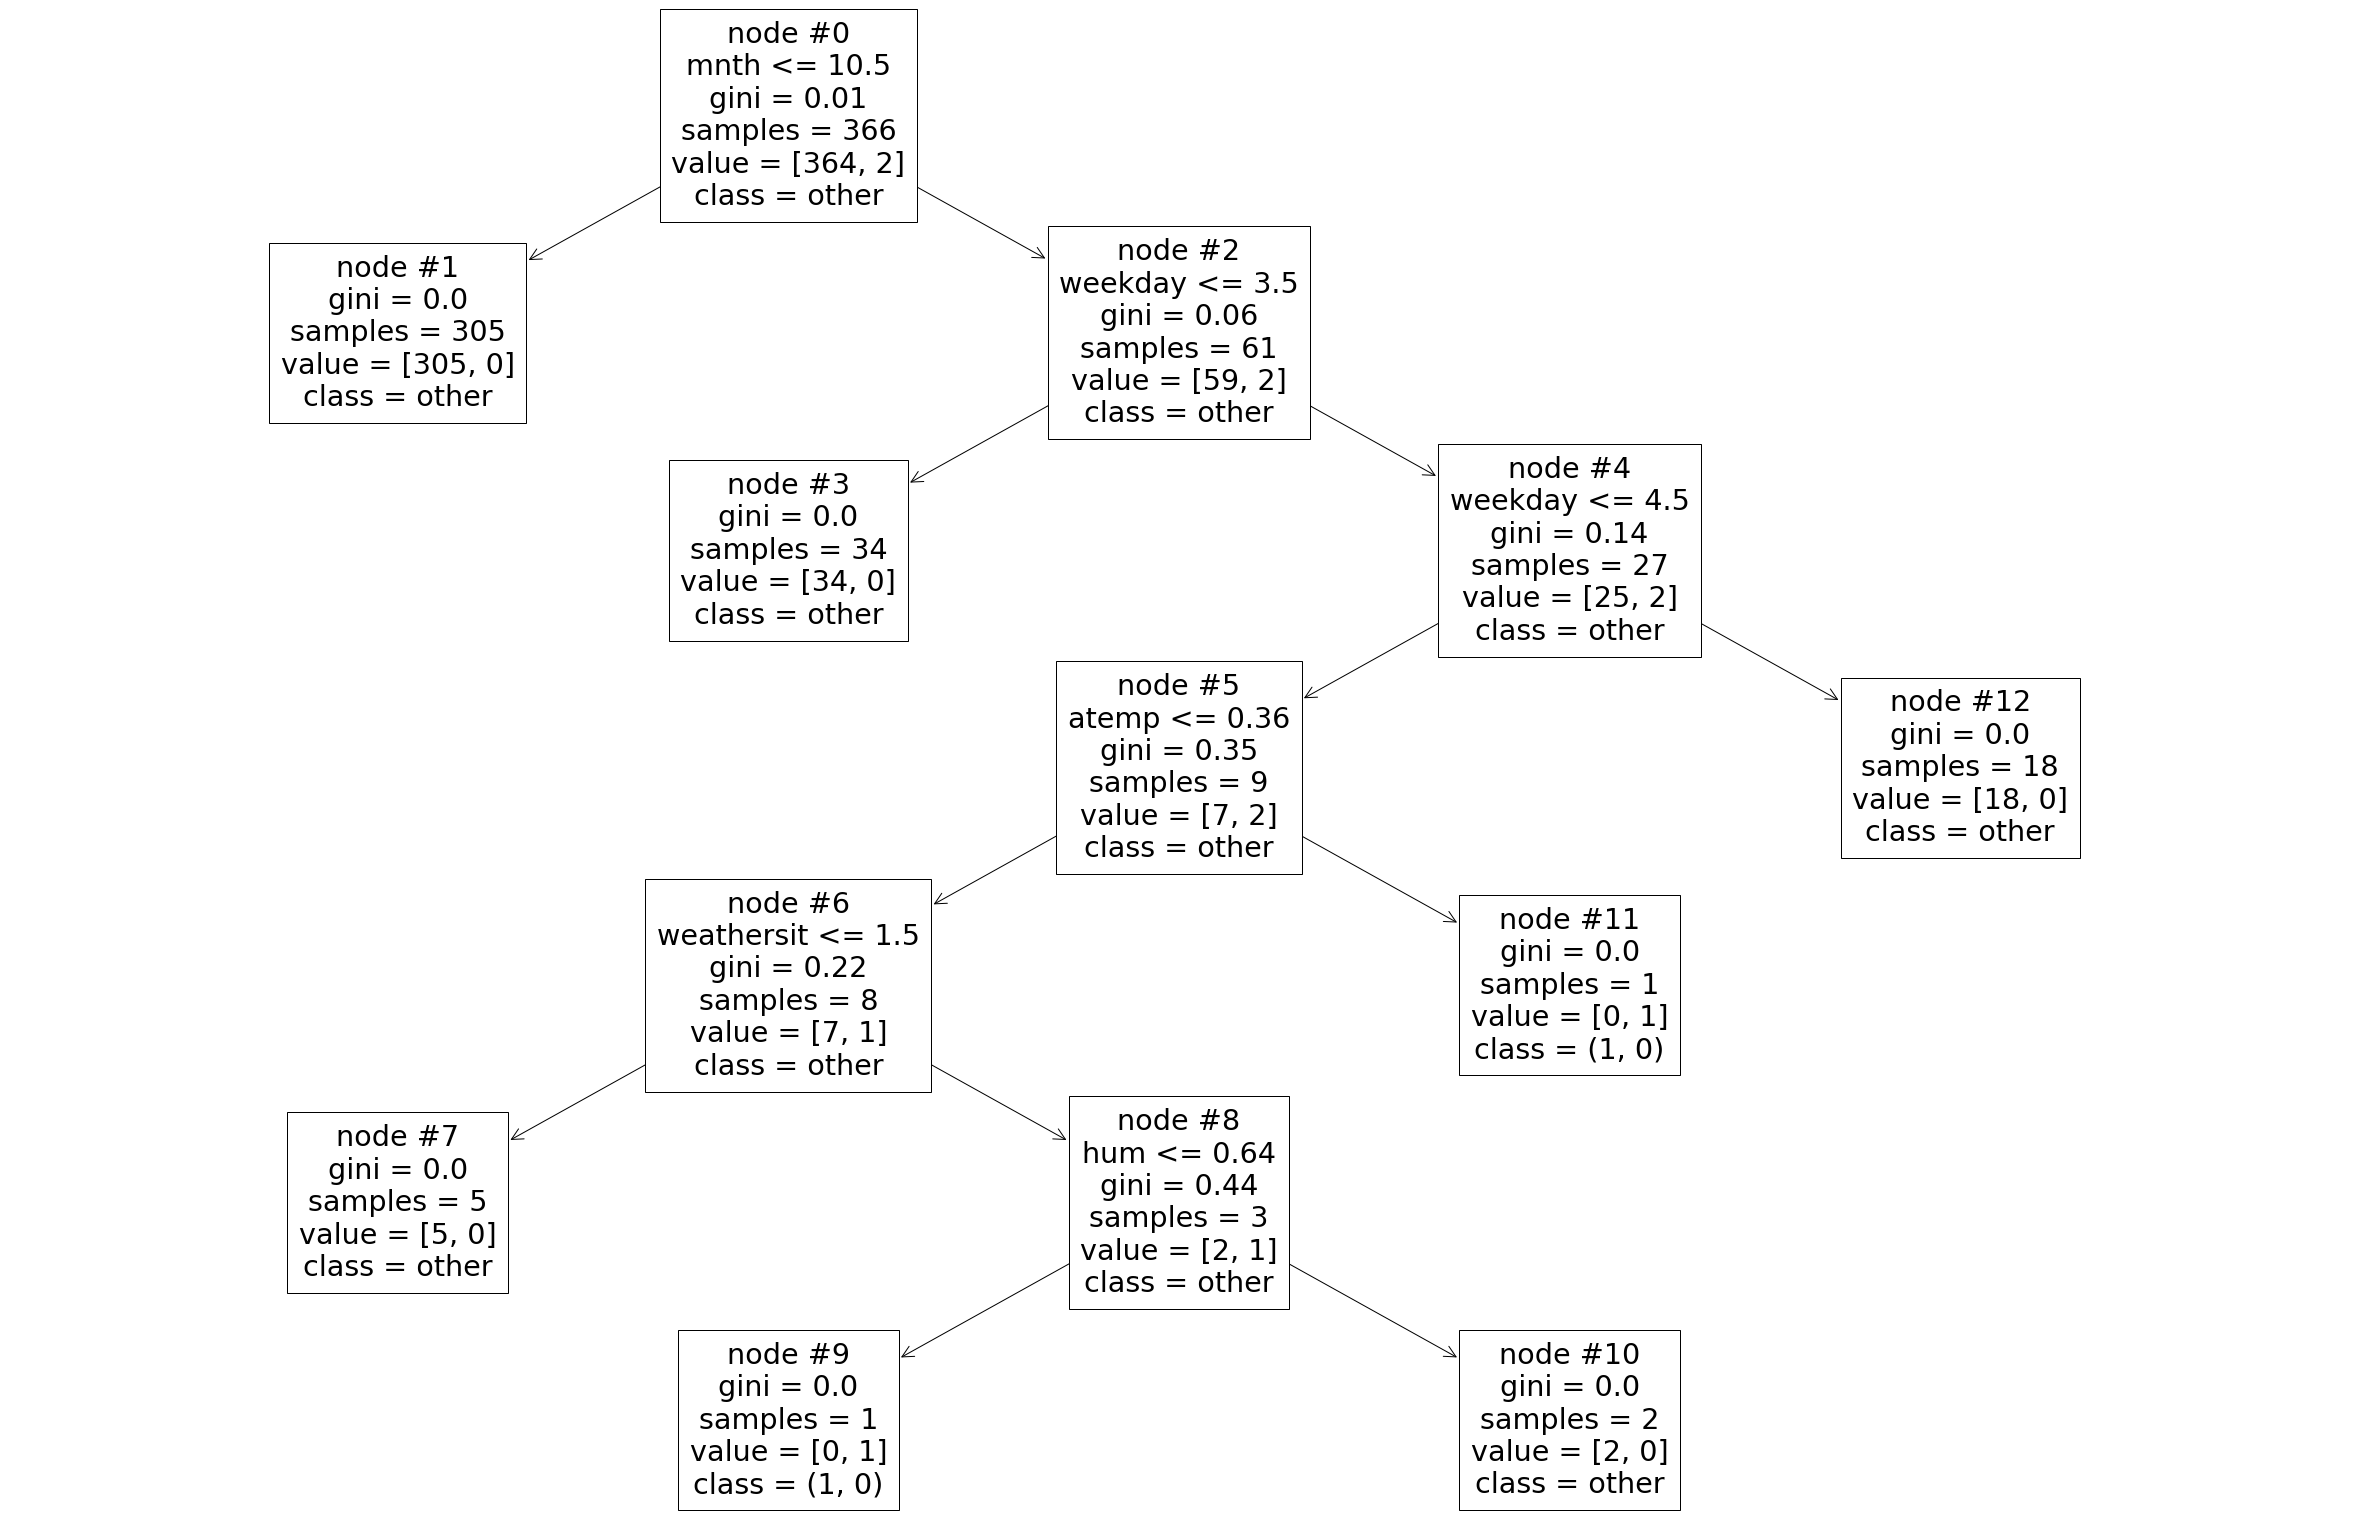

In [27]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(mclass_tree, feature_names=comparer.feature_names, class_names=class_names, ax=ax, precision=2, node_ids=True);

In [28]:
print_rules(mclass_tree, feature_names, class_names, focus_class, feature_order, precision=3)

node #11: if (atemp > 0.36) and (weekday > 3.5) and (weekday <= 4.5) and (mnth > 10.5) then class: (1, 0) (1/1 instances)
node #9: if (atemp <= 0.36) and (hum <= 0.637) and (weekday > 3.5) and (weekday <= 4.5) and (weathersit > 1.5) and (mnth > 10.5) then class: (1, 0) (1/1 instances)


A predicts the positive class where B still predicts the negative class in just 2 cases. This happens when mnth is November or December, weekday is thursday and either temp not very low or temp very low, hum not too high and bad weathersit.

Simplified, $(1,0)$ occurs if:
$0.15 < windspeed < 0.16, 11 ≤ mnth$